I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from catboost import CatBoostClassifier, Pool
# from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
# targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

# ----------------Locally load data
targets = pd.read_csv('./train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [3]:
train_dtypes = {"session_id": pl.Int64,"elapsed_time": pl.Int64,"event_name": pl.Categorical,
                "name": pl.Categorical,"level": pl.Int8,"page": pl.Float32,
                "room_coor_x": pl.Float32,"room_coor_y": pl.Float32,"screen_coor_x": pl.Float32,
                "screen_coor_y": pl.Float32,"hover_duration": pl.Float32,"text": pl.Utf8,
                "fqid": pl.Utf8,"room_fqid": pl.Categorical,"text_fqid": pl.Utf8,
                "fullscreen": pl.Int8,"hq": pl.Int8,"music": pl.Int8,"level_group": pl.Categorical
               }

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [5]:
%%time

# we prepare the dataset for the training by level :
"""df = (pl.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))"""
#df = reduce_mem_usage_pl(df)

# ----------------Locally load data
df = (pl.read_csv("./train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

print(f'df loaded with shape: {df.shape}')

df loaded with shape: (26296946, 18)
CPU times: user 25.3 s, sys: 12.2 s, total: 37.5 s
Wall time: 9.29 s


In [6]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

print(f'df1 loaded with shape: {df1.shape}')
print(f'df2 loaded with shape: {df2.shape}')
print(f'df3 loaded with shape: {df3.shape}')

del df
gc.collect()

df1 loaded with shape: (3981005, 18)
df2 loaded with shape: (8844238, 18)
df3 loaded with shape: (13471703, 18)


92

In [7]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

"""event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']"""

combined_name_feature = [['checkpoint', 'basic'], 
['cutscene_click', 'basic'], 
['map_click', 'basic'], 
['map_click', 'close'],
['map_click', 'undefined'], 
['map_hover', 'basic'], 
['navigate_click', 'undefined'], 
['notebook_click', 'basic'], 
['notebook_click', 'close'],
['notebook_click', 'next'], 
['notebook_click', 'open'],
['notebook_click', 'prev'], 
['notification_click', 'basic'], 
['object_click', 'basic'], 
['object_click', 'close'], 
['object_hover', 'basic'], 
['object_hover', 'undefined'], 
['observation_click', 'basic'], 
['person_click', 'basic'],]

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]


# ----------------From another Notebook https://www.kaggle.com/code/xiaosufrankhu/lgbm-train-infer-with-cpu
# DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
DIALOGS = ['Gramps','myself', 'national movement', 'Wisconsin Wonders','Earth Day', '1916', 'cleaning', 'cleaner', 'slip', 'jersey', 'Theodora Youmans', 'suffragist', 'that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [8]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.25).alias(f"{c}_q25_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.75).alias(f"{c}_q75_{feature_suffix}") for c in NUMS],

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.25).alias(f'word_q25_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.75).alias(f'word_q75_{c}') for c in DIALOGS],

        *[pl.col("event_name").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).count().alias(f"{c[0]+'_'+c[1]}_event_name_counts{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_ET_mean_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_ET_std_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_ET_median_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_ET_q25_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_ET_q75_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_ET_sum_{feature_suffix}") for c in combined_name_feature],
        
        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in LEVELS],
        
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in text_lists],
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in room_lists],
        
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in fqid_lists],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [9]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print(f'df1 done with shape: {df1.shape}')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print(f'df2 done with shape: {df2.shape}')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print(f'df3 done with shape: {df3.shape}')

df1 done with shape: (23562, 2464)
df2 done with shape: (23562, 2470)
df3 done with shape: (23562, 2468)
CPU times: user 6min 54s, sys: 8.16 s, total: 7min 2s
Wall time: 1min 11s


In [10]:
#-----------------------Break Session ID into different terms e.g. year, month, day, hour
def time_feature(train):
    
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)

    return train


df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

Remove some redundant features

In [11]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

1476 1128 996


  0%|          | 0/2470 [00:00<?, ?it/s]

word_myself
word_national movement
word_Earth Day
word_cleaning
word_cleaner
word_Theodora Youmans
word_suffragist
word_found
word_wells
word_Oh
word_flag
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tuni

  0%|          | 0/2476 [00:00<?, ?it/s]

word_myself
word_national movement
word_Wisconsin Wonders
word_Earth Day
word_jersey
word_Found
word_notebook
word_wells
word_flag
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tunic.historicalsociety.basement.seescratches_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.flaghouse.entry.flag_girl.hello_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.historicalsociety.basement.ch3start_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_flag_text_fqid

  0%|          | 0/2474 [00:00<?, ?it/s]

word_Wisconsin Wonders
word_1916
word_cleaning
word_cleaner
word_slip
word_jersey
word_Theodora Youmans
word_suffragist
word_Found
word_notebook
word_wells
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.library.frontdesk.worker.hello_text_fqid_counts
tunic.library.frontdesk.worker.wells_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.hello_text_fqid_coun

In [12]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [13]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 761 1177 1348 features
We will train with 23562 users info


In [14]:
# Make a train_test_split for a test set which will be used for feature engineering

total_train_idx,total_test_idx,_,_ = train_test_split(ALL_USERS, np.zeros((len(ALL_USERS),1)), test_size=0.2, random_state=42)
# train_idx, test_idx

df1_train, df1_test = df1.loc[total_train_idx], df1.loc[total_test_idx]
df2_train, df2_test = df2.loc[total_train_idx], df2.loc[total_test_idx]
df3_train, df3_test = df3.loc[total_train_idx], df3.loc[total_test_idx]

In [ ]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(total_train_idx),18)), index=total_train_idx, columns=[f'meta_{i}' for i in range(1, 19)])

models = {}
results = [[[], []] for _ in range(18)]

best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_train
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2_train
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3_train
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    cat_params = {
        'iterations': 1000,
        'early_stopping_rounds': 90,
        'depth': 5,
        'learning_rate': 0.02,
        'loss_function': "Logloss",
        'random_seed': 42,
        'metric_period': 1,
        'verbose': 0,
        'l2_leaf_reg': 20,
        'task_type': 'GPU',
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, val_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[val_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # pool DATA
        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        # TRAIN MODEL        
        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set=valid_pool)
        print(i+1, ', ', end='')

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(i, t)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL
        # clf.save_model(f'XGB_question{t}_fold{i}.xgb')

        # PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = model.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]



    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    feature_importance_df.to_csv(f'feature_importance_question{t}.csv')
    display(feature_importance_df.head(10))


In [17]:
# Save the best iteration for xgb model
f_save = open('best_iteration_xgb.pkl', 'wb')
pickle.dump(best_iteration_xgb, f_save)
f_save.close()

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

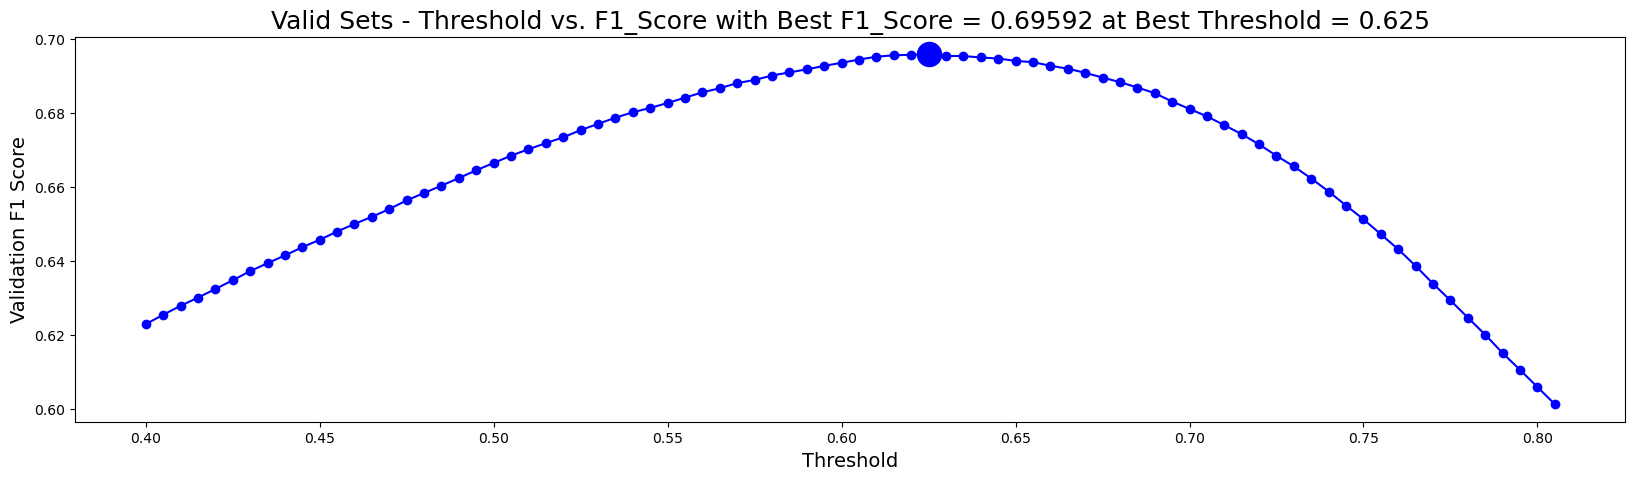

In [18]:
# For the valid data sets combined
true = oof_xgb.copy()

for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[total_train_idx]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Valid Sets - Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
# plt.savefig('BestThreshold.png')
plt.show()

In [19]:
# Print F1 Scores Question by Question
try:
    print('When using optimal threshold...')
    for k in range(1, 19):

        # COMPUTE F1 SCORE PER QUESTION
        m = f1_score(true[f'meta_{k}'].values, (oof_xgb[f'meta_{k}'].values>best_threshold_xgb).astype('int'), average='macro')
        print(f'Q{k}: F1 =',m)
        
except:
    print('Something went wrong.....')

When using optimal threshold...
Q1: F1 = 0.6734765707997739
Q2: F1 = 0.5132792354038375
Q3: F1 = 0.5142969297443457
Q4: F1 = 0.6779860222171092
Q5: F1 = 0.6365694148258139
Q6: F1 = 0.6424507326579655
Q7: F1 = 0.6280656810122232
Q8: F1 = 0.5679786498478407
Q9: F1 = 0.6291698928132596
Q10: F1 = 0.5824495315136669
Q11: F1 = 0.6095122051259303
Q12: F1 = 0.5124785269285443
Q13: F1 = 0.4647769833777543
Q14: F1 = 0.6327429565639717
Q15: F1 = 0.5986773934007871
Q16: F1 = 0.4872873238880695
Q17: F1 = 0.5468673376180523
Q18: F1 = 0.5016956476411121


Now we use full data to retrain our models with the best iterations, and save them. 

In [24]:
# Train the model again with all data but selected features from the cross_val dump into pickle

feature_dict={}
for t in range(1,19):
    feat_tmp = pd.read_csv(f'./feature_importance_question{t}.csv')

    if t<=3: 
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:250, 'feature']
    elif t<=13: 
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:400, 'feature']
    elif t<=22:
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:400, 'feature']

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(feature_dict, f_save)
f_save.close()

In [25]:
# Use all the data to train the final model

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_train
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2_train
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3_train
        FEATURES = feature_dict[str(t)]
    
    # n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    cat_params = {
        'iterations': 1000,
        'early_stopping_rounds': 90,
        'depth': 5,
        'learning_rate': 0.02,
        'loss_function': "Logloss",
        'random_seed': 42,
        'metric_period': 1,
        'verbose': 0,
        'l2_leaf_reg': 20,
        'task_type': 'GPU',
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # pool DATA
    train_pool = Pool(df[FEATURES].astype('float32'), train_y['correct'])  

    # TRAIN MODEL        
    model = CatBoostClassifier(**cat_params)
    model = model.fit(train_pool)
    model.save_model(f'CatGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 250

#########################
### question 2 features 250

#########################
### question 3 features 250

#########################
### question 4 features 400

#########################
### question 5 features 400

#########################
### question 6 features 400

#########################
### question 7 features 400

#########################
### question 8 features 400

#########################
### question 9 features 400

#########################
### question 10 features 400

#########################
### question 11 features 400

#########################
### question 12 features 400

#########################
### question 13 features 400

#########################
### question 14 features 400

#########################
### question 15 features 400

#########################
### question 16 features 400

#########################
### question 17 features 400

#########################
### question 18 features 400



We save features names as dict for each questions

In [26]:
# For the test set that were ruled out before training
# All zeros
test_xgb = pd.DataFrame(data=np.zeros((len(total_test_idx),18)), index=total_test_idx, columns=[f'meta_{i}' for i in range(1, 19)])

# Copy to store true value
true = test_xgb.copy()
threshold_xgb = 0.625

for t in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==t].set_index('session').loc[total_test_idx]
    true[f'meta_{t}'] = tmp.correct.values

    # PREDICT THE PROBA OF LABELS
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_test
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2_test
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3_test
        FEATURES = feature_dict[str(t)]
    
    model = CatBoostClassifier()
    model.load_model(f'./CatGB_question{t}.xgb')
    test_xgb.loc[total_test_idx, f'meta_{t}'] = model.predict_proba(df[FEATURES].astype('float32'))[:,1]
    # F1 Score for each question
    qm = f1_score(true[f'meta_{t}'].values, (model.predict_proba(df[FEATURES].astype('float32'))[:,1]>threshold_xgb).astype(int), average='macro')
    print(f'The question{t} f1 score for the test set is: {qm}')
    
preds = (test_xgb.values.reshape((-1))>threshold_xgb).astype('int')
m = f1_score(true.values.reshape((-1)), preds, average='macro')   

print(f'The overall f1 score for the test set is: {m}')

The question1 f1 score for the test set is: 0.6674627755218123
The question2 f1 score for the test set is: 0.5042920265050731
The question3 f1 score for the test set is: 0.5311628785493925
The question4 f1 score for the test set is: 0.6615805319170938
The question5 f1 score for the test set is: 0.6240173238520212
The question6 f1 score for the test set is: 0.6410493145986503
The question7 f1 score for the test set is: 0.6170286138981792
The question8 f1 score for the test set is: 0.5689849080826218
The question9 f1 score for the test set is: 0.6254397954931746
The question10 f1 score for the test set is: 0.5756157672275157
The question11 f1 score for the test set is: 0.6132453585462694
The question12 f1 score for the test set is: 0.5191335473518749
The question13 f1 score for the test set is: 0.47991726977134463
The question14 f1 score for the test set is: 0.6487966714684298
The question15 f1 score for the test set is: 0.5975690207037936
The question16 f1 score for the test set is: 0.5

In [64]:
# FINALLY Train models with all the data for submission
# Use all the data to train the final model

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = feature_dict[str(t)]
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 250

#########################
### question 2 features 250

#########################
### question 3 features 250

#########################
### question 4 features 800

#########################
### question 5 features 800

#########################
### question 6 features 800

#########################
### question 7 features 800

#########################
### question 8 features 800

#########################
### question 9 features 800

#########################
### question 10 features 800

#########################
### question 11 features 800

#########################
### question 12 features 800

#########################
### question 13 features 800

#########################
### question 14 features 800

#########################
### question 15 features 800

#########################
### question 16 features 800

#########################
### question 17 features 800

#########################
### question 18 features 800

